<a href="https://colab.research.google.com/github/hyukstory/hyukstory_AI/blob/main/%5BDACON%5D%20%EC%86%8C%EC%84%A4%20%EC%9E%91%EA%B0%80%20%EB%B6%84%EB%A5%98%20AI%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C%20%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

# 1.NLP Preprocessing


## 1-1. 데이터 불러오기

In [ ]:
# train 데이터 불러오기
train = pd.read_csv("/content/drive/MyDrive/dacon_data/train.csv")
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [ ]:
# test 데이터 불러오기
test = pd.read_csv("/content/drive/MyDrive/dacon_data/test_x.csv")
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


In [ ]:
# sample_submission 불러오기
sample_submission = pd.read_csv("/content/drive/MyDrive/dacon_data/sample_submission.csv")
sample_submission

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
19612,19612,0,0,0,0,0
19613,19613,0,0,0,0,0
19614,19614,0,0,0,0,0
19615,19615,0,0,0,0,0


## 1-2. 불용어 제거

In [ ]:
# 부호 제거해주는 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

# 소문자로 바꾼 후 전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

## 1-3. 데이터 시각화

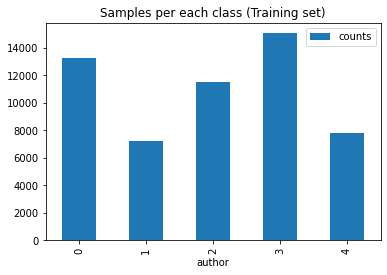

In [ ]:
# 작가별 분포도 확인 
train.groupby(train.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)")

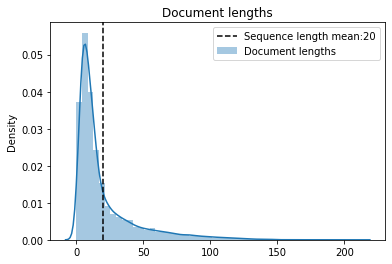

 가장 긴 문장은 211 개의 단어를, 가장 짧은 문장은 0 개의 단어를 가지고 있습니다.


In [ ]:
# 문장 길이 분포도 확인
train['doc_len'] = train.text.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(train)

위 그래프에서 확인했듯 평균 길이는 20 인 것을 알 수 있다.
차후 sequence에 적용할 max length는 150 정도로 적당히 잡아준다

# 2.Vectorization

## 2.1 Tokenization

In [ ]:
# 먼저 train 데이터와 test 데이터 인덱스 없이 배열로 만들기
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
Y_train = np.array([x for x in train['author']])

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(54879,)
(19617,)
(54879,)


In [ ]:
print(X_train)
print(X_test)
print(Y_train)

['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity'
 'sister asked suppose'
 'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said'
 ... 'sincere wellwisher friend sister lucy odin' 'wanted lend money'
 'certainly not occurred said yes like']
['not think one charming young ladies ever met might useful work decided genius way witness way preserved agra plan papers father love emotional thing whatever emotional opposed true cold reason place things never marry lest bias judgment'
 'no replied sudden consciousness not find cannot ignorant goodness owe alli feel iti express couldbut well know no orator'
 'lady stated intention screaming course screamed additional boldness exertion rendered unnecessary hasty knocking door no sooner heard mr odin darted much ag

In [ ]:
# Tokenizer
from keras.preprocessing.text import Tokenizer
vocab_size = 2000  

tokenizer = Tokenizer(num_words = vocab_size)  
  # Tokenizer 는 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서 
  # num_words 에 지정된 만큼만 숫자로 반환하고, 나머지는 0 으로 반환합니다                 
tokenizer.fit_on_texts(X_train) # Tokenizer 에 데이터 실제로 입력
sequences_train = tokenizer.texts_to_sequences(X_train)    # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_test = tokenizer.texts_to_sequences(X_test)      # 문장 내 모든 단어를 시퀀스 번호로 변환

print(len(sequences_train), len(sequences_test))

54879 19617


# 3.Embediing

In [ ]:
# 변환된 시퀀스 번호를 이용해 단어 임베딩 벡터 생성
word_index = tokenizer.word_index

In [ ]:
# 독립변수 데이터 전처리
  ## 문장의 길이기 제각각이기 때문에 벡터 크기 다 다름
  ## 그러므로 최대 시퀀스 길이 크기(211) 만큼 넉넉하게 늘리고
  ## 패딩(padding) 작업을 통해 나머지 빈 공간을 0으로 채움
max_length = 150    # 위에서 그래프 확인 후 정함
padding_type='post'

train_x = pad_sequences(sequences_train, padding='post', maxlen=max_length)
test_x = pad_sequences(sequences_test, padding=padding_type, maxlen=max_length)

print(train_x.shape, test_x.shape)

(54879, 150) (19617, 150)


In [ ]:
# 종속변수 데이터 전처리
train_y = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩
print(train_y)
print(train_y.shape)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
(54879, 5)


# 4.Modeling 

## 4.1 simple RNN

In [ ]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 150    # 위에서 그래프 확인 후 정함
padding_type='post'

In [ ]:
# Simple RNN 레이어를 사용한 모델 (model1) 정의
model1 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
        tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
        tf.keras.layers.SimpleRNN(units = 64),
        Dense(5, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
model1.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 200)          400000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 150, 64)           16960     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 150, 64)           8256      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 433,797
Trainable params: 433,797
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 실행해보기
history = model1.fit(train_x, train_y, epochs=10, batch_size=100, validation_split= 0.2) 
  # 데이터가 50000개가 넘어 학습시간이 오래 걸리기 때문에 batch size 를 100으로 크게 잡았다
  # 추이를 확인하게 위해 일단 10회만 시도

Epoch 1/10
440/440 [==============================] - 145s 329ms/step - loss: 1.5742 - accuracy: 0.2698 - val_loss: 1.5712 - val_accuracy: 0.2680
Epoch 2/10
440/440 [==============================] - 146s 331ms/step - loss: 1.5733 - accuracy: 0.2715 - val_loss: 1.5717 - val_accuracy: 0.2680
Epoch 3/10
440/440 [==============================] - 144s 328ms/step - loss: 1.5730 - accuracy: 0.2723 - val_loss: 1.5783 - val_accuracy: 0.2680
Epoch 4/10
440/440 [==============================] - 141s 321ms/step - loss: 1.5732 - accuracy: 0.2718 - val_loss: 1.5722 - val_accuracy: 0.2680
Epoch 5/10
440/440 [==============================] - 144s 326ms/step - loss: 1.5727 - accuracy: 0.2716 - val_loss: 1.5754 - val_accuracy: 0.2680
Epoch 6/10
440/440 [==============================] - 143s 324ms/step - loss: 1.5728 - accuracy: 0.2718 - val_loss: 1.5744 - val_accuracy: 0.2680
Epoch 7/10
440/440 [==============================] - 143s 325ms/step - loss: 1.5730 - accuracy: 0.2697 - val_loss: 1.5769 -

<function matplotlib.pyplot.show>

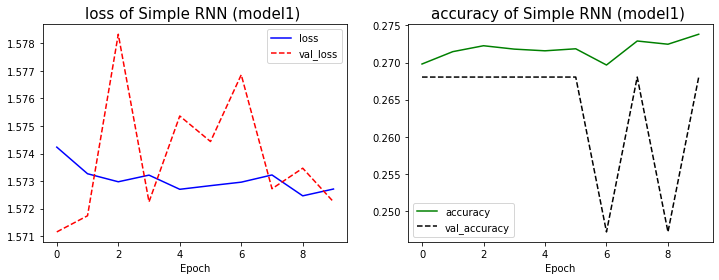

In [ ]:
# Simple RNN 모델 (model1) 학습 결과 확인
plt.figure(figsize=(12, 4))
plt.title('Simple RNN (model1) ', fontsize= 15)

plt.subplot(1, 2, 1)
plt.title('loss of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

Simple RNN는 Epoch 한번 당 시간도 오래 걸리고, 학습이 되지 않는 것을 확인할 수 있다.

## 4.2 단방향 LSTM

In [ ]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 150    # 위에서 그래프 확인 후 정함
padding_type='post'

In [ ]:
# LSTM 레이어를 사용한 모델 (model2) 정의
model2 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64),
        Dense(5, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
model2.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 200)          400000    
_________________________________________________________________
lstm (LSTM)                  (None, 150, 64)           67840     
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 64)           33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 534,213
Trainable params: 534,213
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 실행해보기
history = model2.fit(train_x, train_y, epochs=10, batch_size=100, validation_split= 0.2) 
  # 데이터가 50000개가 넘어 학습시간이 오래 걸리기 때문에 batch size 를 100으로 크게 잡았다
  # 추이를 확인하게 위해 일단 10회만 시도

Epoch 1/10
440/440 [==============================] - 14s 32ms/step - loss: 1.5702 - accuracy: 0.2761 - val_loss: 1.5714 - val_accuracy: 0.2680
Epoch 2/10
440/440 [==============================] - 14s 33ms/step - loss: 1.5701 - accuracy: 0.2761 - val_loss: 1.5711 - val_accuracy: 0.2680
Epoch 3/10
440/440 [==============================] - 15s 33ms/step - loss: 1.5702 - accuracy: 0.2761 - val_loss: 1.5715 - val_accuracy: 0.2680
Epoch 4/10
440/440 [==============================] - 14s 32ms/step - loss: 1.5702 - accuracy: 0.2761 - val_loss: 1.5715 - val_accuracy: 0.2680
Epoch 5/10
440/440 [==============================] - 15s 33ms/step - loss: 1.5702 - accuracy: 0.2761 - val_loss: 1.5715 - val_accuracy: 0.2680
Epoch 6/10
440/440 [==============================] - 14s 32ms/step - loss: 1.5702 - accuracy: 0.2761 - val_loss: 1.5717 - val_accuracy: 0.2680
Epoch 7/10
440/440 [==============================] - 14s 32ms/step - loss: 1.5701 - accuracy: 0.2761 - val_loss: 1.5713 - val_accuracy:

<function matplotlib.pyplot.show>

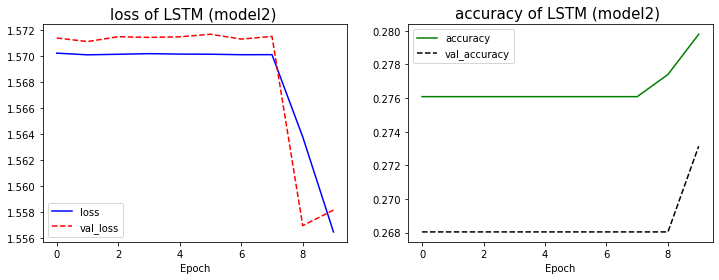

In [ ]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

학습 시간은 단축되었지만, 단방향 LSTM 으로도 학습이 되지 않는 것을 확인할 수 있다.

## 4.3 양방향 LSTM

In [ ]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 150    # 위에서 그래프 확인 후 정함
padding_type='post'
#oov_tok = "<OOV>"

In [ ]:
# 양방향 LSTM 레이어를 사용한 모델 (model3) 정의
model3 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(5, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
model3.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 200)          400000    
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 128)          135680    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 128)          98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 733,957
Trainable params: 733,957
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 실행해보기
history = model3.fit(train_x, train_y, epochs=50, batch_size=100, validation_split= 0.2) 
  # 양방향 LSTM 레이어에서는 batch size 를 100으로 잡고 50회 학습 해보았다.

Epoch 1/50
440/440 [==============================] - 33s 61ms/step - loss: 1.2718 - accuracy: 0.4598 - val_loss: 0.9121 - val_accuracy: 0.6509
Epoch 2/50
440/440 [==============================] - 25s 58ms/step - loss: 0.8615 - accuracy: 0.6714 - val_loss: 0.8917 - val_accuracy: 0.6608
Epoch 3/50
440/440 [==============================] - 25s 58ms/step - loss: 0.7867 - accuracy: 0.6980 - val_loss: 0.8815 - val_accuracy: 0.6649
Epoch 4/50
440/440 [==============================] - 25s 58ms/step - loss: 0.7306 - accuracy: 0.7228 - val_loss: 0.9010 - val_accuracy: 0.6578
Epoch 5/50
440/440 [==============================] - 26s 58ms/step - loss: 0.6956 - accuracy: 0.7352 - val_loss: 0.9048 - val_accuracy: 0.6579
Epoch 6/50
440/440 [==============================] - 25s 58ms/step - loss: 0.7030 - accuracy: 0.7317 - val_loss: 0.9321 - val_accuracy: 0.6602
Epoch 7/50
440/440 [==============================] - 25s 58ms/step - loss: 0.6512 - accuracy: 0.7505 - val_loss: 0.9558 - val_accuracy:

<function matplotlib.pyplot.show>

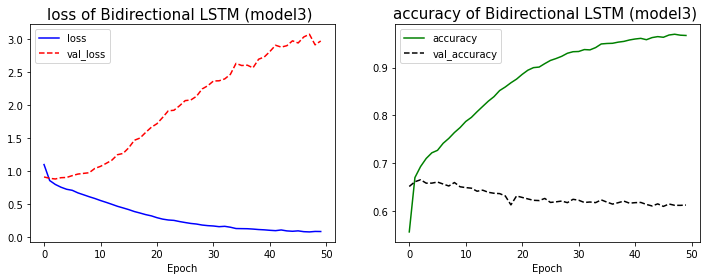

In [ ]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM (model3) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM (model3) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

loss 값은 줄어드는 것을 볼 수 있으나, val_loss 값은 점점 상승한다
accuracy 도 마찬가지로 val_accuracy 는 제대로 결과가 나오지 않는다.

모델 성능 평가의 일반화를 위해 교차 검증을 해야할 것 같다.

## 4.4 교차 검증 적용

- 계층 교차검증(StratifiedKFold) 적용하고 모델 일반화

In [ ]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512)

training model for CV #1
Epoch 1/10
86/86 [==============================] - 13s 149ms/step - loss: 0.5091 - accuracy: 0.8998 - val_loss: 0.4110 - val_accuracy: 0.9027
Epoch 2/10
86/86 [==============================] - 13s 149ms/step - loss: 0.3221 - accuracy: 0.9212 - val_loss: 0.3957 - val_accuracy: 0.9042
Epoch 3/10
86/86 [==============================] - 13s 149ms/step - loss: 0.2691 - accuracy: 0.9317 - val_loss: 0.3942 - val_accuracy: 0.9032
Epoch 4/10
86/86 [==============================] - 13s 150ms/step - loss: 0.2358 - accuracy: 0.9392 - val_loss: 0.3976 - val_accuracy: 0.9032
Epoch 5/10
86/86 [==============================] - 13s 150ms/step - loss: 0.2094 - accuracy: 0.9438 - val_loss: 0.4050 - val_accuracy: 0.9023
Epoch 6/10
86/86 [==============================] - 13s 149ms/step - loss: 0.1880 - accuracy: 0.9493 - val_loss: 0.4139 - val_accuracy: 0.9014
Epoch 7/10
86/86 [==============================] - 13s 150ms/step - loss: 0.1699 - accuracy: 0.9529 - val_loss: 0.42

기존 보다 개선된 결과 값을 보여준다.
하지만 val_loss 와 val_accuracy 결과값을 보면 조기종료 옵션을 추가해야할 것 같다.

In [ ]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
test_y = np.zeros((test_x.shape[0], 5))

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])     # 조기 종료 옵션
                      
    test_y += model3.predict(test_x) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다

training model for CV #1
Epoch 1/10
86/86 [==============================] - 13s 148ms/step - loss: 0.0559 - accuracy: 0.9787 - val_loss: 0.0533 - val_accuracy: 0.9800
Epoch 2/10
86/86 [==============================] - 13s 147ms/step - loss: 0.0496 - accuracy: 0.9809 - val_loss: 0.0577 - val_accuracy: 0.9785
Epoch 3/10
86/86 [==============================] - 13s 148ms/step - loss: 0.0429 - accuracy: 0.9828 - val_loss: 0.0590 - val_accuracy: 0.9779
Epoch 4/10
86/86 [==============================] - 13s 148ms/step - loss: 0.0401 - accuracy: 0.9830 - val_loss: 0.0604 - val_accuracy: 0.9774
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
training model for CV #2
Epoch 1/10
86/86 [==============================] - 13s 148ms/step - loss: 0.0489 - accuracy: 0.9810 - val_loss: 0.0511 - val_accuracy: 0.9793
Epoch 2/10
86/86 [==============================] - 13s 149ms/step - loss: 0.0445 - accuracy: 0.9825 - val_loss: 0.0552 - val_accuracy: 0.9777
Epoch 3/

## 4.5 테스트 데이터 적용

In [ ]:
# 테스트 데이터의 예측값 확인
test_y

array([[1.81669971e-05, 9.99980405e-01, 2.21813224e-07, 5.60680022e-07,
        6.63153550e-07],
       [9.75581124e-01, 2.40880114e-02, 5.76216680e-06, 9.64506868e-06,
        3.15430785e-04],
       [9.99998584e-01, 1.72124270e-07, 2.76427015e-08, 7.37292122e-07,
        5.00387213e-07],
       ...,
       [6.15026284e-07, 9.99999076e-01, 2.41515011e-08, 5.40485090e-09,
        2.95169057e-07],
       [2.28504870e-04, 9.99768451e-01, 7.58608628e-07, 1.59446323e-06,
        6.56659445e-07],
       [2.15525821e-07, 1.21122843e-07, 9.99998808e-01, 2.01716647e-07,
        6.58718623e-07]])

In [ ]:
# sample_submission 에 대입
sample_submission[['0','1','2','3','4']] = test_y
sample_submission

,index,0,1,2,3,4
0,0,1.816700e-05,9.999804e-01,2.218132e-07,5.606800e-07,6.631535e-07
1,1,9.755811e-01,2.408801e-02,5.762167e-06,9.645069e-06,3.154308e-04
2,2,9.999986e-01,1.721243e-07,2.764270e-08,7.372921e-07,5.003872e-07
3,3,1.778851e-06,2.258285e-05,9.998666e-01,3.783720e-08,1.090297e-04
4,4,9.969966e-01,1.781352e-06,3.257030e-06,2.626987e-03,3.713835e-04
...,...,...,...,...,...,...
19612,19612,1.667222e-05,9.999828e-01,1.346626e-08,2.516321e-07,2.284147e-07
19613,19613,1.058177e-05,1.542253e-05,7.148389e-04,3.804064e-05,9.992211e-01
19614,19614,6.150263e-07,9.999991e-01,2.415150e-08,5.404851e-09,2.951691e-07
19615,19615,2.285049e-04,9.997685e-01,7.586086e-07,1.594463e-06,6.566594e-07


# E.O.D